<a href="https://colab.research.google.com/github/montonenbc/ml_models/blob/main/IBM_Employee_Attrition_MIKA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'employee:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F735927%2F1480240%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240416%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240416T113840Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5a1fc9c6f457dd1c23d6301db877512b7bef896259f922c8f8dba48118b684febc995fe39f2c3619fd93f7563526674d03eab296d708517eb97888957b0cec750404a534aa49875a905d032540d49c6785ce6ad71571a14b2475767b7765cbe3b915222cf16ec05e84ef8f8b069d67c31841bfc48eac8e097948efb6b8e84f0acc088a791b388427c61497fd06a5851cfe8705d51ff14ba6e9f4052b82e7e57c1cb29ab735815c47bcf45502ee0401fc8388d43c1206aa5c1842e43e5a779bd948ea1776364bf44420573ea8ecb96c09804e79019fc14d39af99b7bc6277939971f46924600aa65eccc908b5e9331685b2abc4144da6ecf5fc730da775fa36a7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 52160 bytes downloaded
Downloaded and uncompressed: employee
Data source import complete.


# **The IBM Employee Attrition Dataset**

# **Background Information**

Attrition is a problem that impacts all businesses, irrespective of geography, industry and size of the company. Employee attrition leads to significant costs for a business, including the cost of business disruption, hiring new staff and training new staff. As such, there is great business interest in understanding the drivers of, and minimizing staff attrition. Let us therefore turn to our predictive modelling capabilities and see if we can predict employee attrition on this IBM dataset.

# **Import Libraries**

In [2]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##### import train and test sets

In [3]:
train_url = '/kaggle/input/employee/train.csv'
test_url = '/kaggle/input/employee/test.csv'

train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

train_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
test_df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,34,Travel_Rarely,790,Sales,24,4,Medical,1,1489,1,...,3,80,0,16,2,4,15,9,10,10
1,35,Travel_Rarely,660,Sales,7,1,Life Sciences,1,1492,4,...,1,80,1,1,3,3,1,0,0,0
2,24,Travel_Frequently,381,Research & Development,9,3,Medical,1,1494,2,...,3,80,0,4,2,2,0,0,0,0
3,24,Non-Travel,830,Sales,13,2,Life Sciences,1,1495,4,...,3,80,1,1,2,3,1,0,0,0
4,44,Travel_Frequently,1193,Research & Development,2,1,Medical,1,1496,2,...,2,80,0,16,2,2,2,2,2,2


now we have to concat the two dataframes we made above to preprocess the data (all the dataset)

In [5]:
dropped=train_df.drop('Attrition',axis=1)
df=pd.concat([dropped,test_df],axis=0)

note that we dropped the target column from the train set then we concat the two sets

# **Data Exploration & Preprocessing**

In [ ]:
df.shape

(1470, 34)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 0 to 411
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   BusinessTravel            1470 non-null   object
 2   DailyRate                 1470 non-null   int64 
 3   Department                1470 non-null   object
 4   DistanceFromHome          1470 non-null   int64 
 5   Education                 1470 non-null   int64 
 6   EducationField            1470 non-null   object
 7   EmployeeCount             1470 non-null   int64 
 8   EmployeeNumber            1470 non-null   int64 
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobLevel                  1470 non-null   int64 
 14  JobRole                  

### check nulls & Duplicates

In [6]:
df.isnull().sum()

Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithC

##### now check if the target column has null values or not

In [7]:
train_df['Attrition'].isnull().sum()

0

In [8]:
duplicates = df.duplicated()
num_duplicates = duplicates.sum()

print("Number of duplicates:", num_duplicates)

Number of duplicates: 0


##### good! we dont have to deal with nulls & duplicates

####  **Now Seperate the Categorical and Numerical attributes**

In [9]:
df.nunique()

Age                           43
BusinessTravel                 3
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1470
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1349
MonthlyRate                 1427
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBalance                4
YearsAtCom

In [ ]:
df.dtypes

Age                          int64
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears            int64
TrainingTimesLastYea

In [10]:
df_num = df.select_dtypes(include=['float64','int64'])
df_cat = df.select_dtypes(include = 'object')
df_cat = pd.get_dummies(df_cat, drop_first=True)

#### **Check & Drop unrelated Columns**

concat both df_num and df_cat

In [11]:
new_df = pd.concat([df_num, df_cat], axis=1)

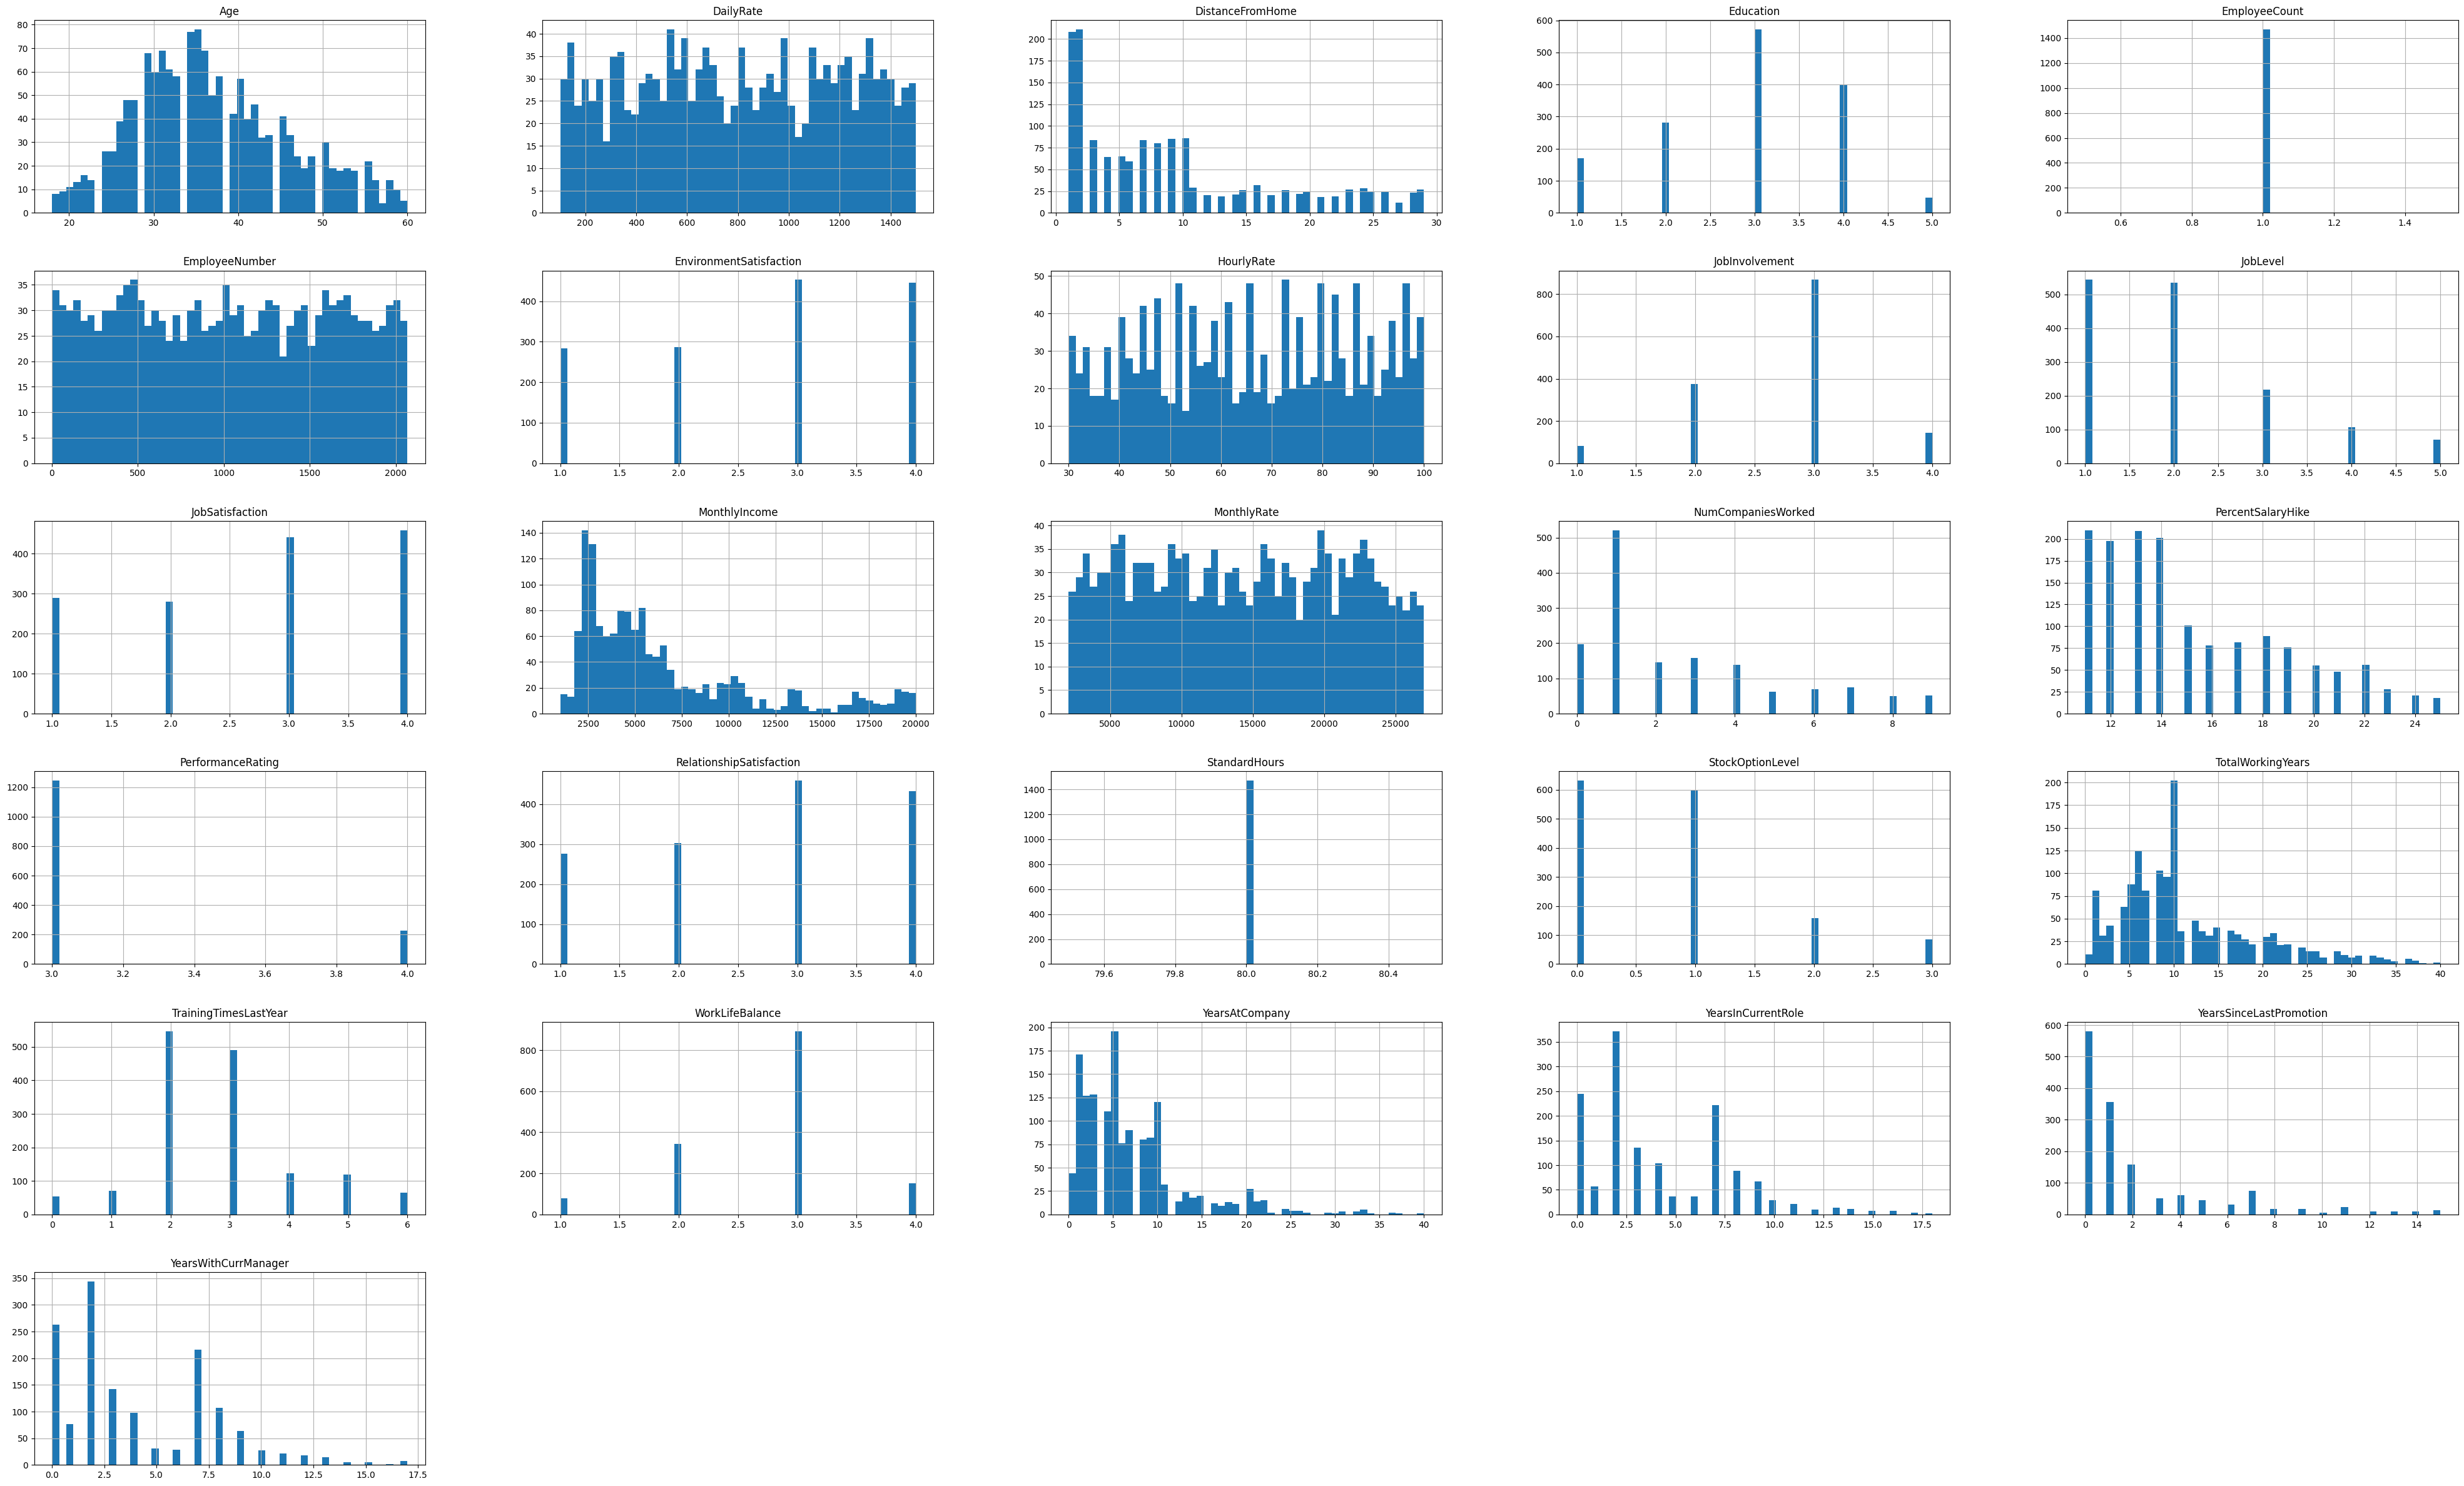

In [12]:
new_df.hist(bins=50, figsize=
 (50,30))
plt.show()

* we can see from the plots above that there are two columns **EmployeeCount, and StandardHours** might be noisy and will not make any difference in the model because these two columns have just 1 value so we can drop them to make our model more efficient

In [13]:
new_df.drop(['EmployeeCount','StandardHours'],axis=1,inplace=True)

# **Correlation**

In [14]:
# correlation matrix
corr = new_df.corr()
corr

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
Age,1.000000,0.010661,-0.001686,0.208034,-0.010145,0.010146,0.024287,0.029820,0.509604,-0.004892,...,-0.143176,0.294248,0.049726,0.185891,-0.146518,-0.002001,-0.175785,0.083919,-0.119185,0.028062
DailyRate,0.010661,1.000000,-0.004985,-0.016806,-0.050990,0.018355,0.023381,0.046135,0.002966,0.030571,...,-0.006728,-0.013224,-0.005302,-0.000021,-0.002624,-0.000513,0.005375,0.040035,-0.075835,0.009135
DistanceFromHome,-0.001686,-0.004985,1.000000,0.021042,0.032916,-0.016075,0.031131,0.008783,0.005303,-0.003669,...,0.012369,-0.039190,0.011848,-0.022351,-0.010986,0.030761,-0.015994,0.030232,-0.027445,0.025514
Education,0.208034,-0.016806,0.021042,1.000000,0.042070,-0.027128,0.016775,0.042438,0.101589,-0.011296,...,-0.063566,0.028453,-0.005290,0.049694,0.000709,0.053398,-0.091465,-0.001865,0.004168,-0.020322
EmployeeNumber,-0.010145,-0.050990,0.032916,0.042070,1.000000,0.017621,0.035179,-0.006888,-0.018519,-0.046247,...,-0.019722,-0.035058,-0.014350,-0.013983,-0.017686,0.023263,0.006255,0.053933,-0.035189,-0.024037
EnvironmentSatisfaction,0.010146,0.018355,-0.016075,-0.027128,0.017621,1.000000,-0.049857,-0.008278,0.001212,-0.006784,...,-0.001533,0.010730,0.059178,-0.048689,0.001940,-0.024421,0.002949,-0.022180,0.009035,0.070132
HourlyRate,0.024287,0.023381,0.031131,0.016775,0.035179,-0.049857,1.000000,0.042861,-0.027853,-0.071335,...,0.018028,0.012659,-0.014394,-0.025128,0.020034,-0.011886,-0.018703,0.036432,-0.033436,-0.007782
JobInvolvement,0.029820,0.046135,0.008783,0.042438,-0.006888,-0.008278,0.042861,1.000000,-0.012630,-0.021476,...,-0.022724,0.017112,-0.021939,0.015200,0.047604,-0.011413,-0.027282,0.028324,-0.045253,-0.003507
JobLevel,0.509604,0.002966,0.005303,0.101589,-0.018519,0.001212,-0.027853,-0.012630,1.000000,-0.001944,...,-0.344608,0.552744,0.114896,0.414319,-0.387788,0.127490,-0.216559,0.050547,-0.087072,0.000544
JobSatisfaction,-0.004892,0.030571,-0.003669,-0.011296,-0.046247,-0.006784,-0.071335,-0.021476,-0.001944,1.000000,...,-0.015710,-0.005620,-0.013747,-0.006217,0.020503,0.012604,0.001413,-0.010315,0.024571,0.024539


<Axes: >

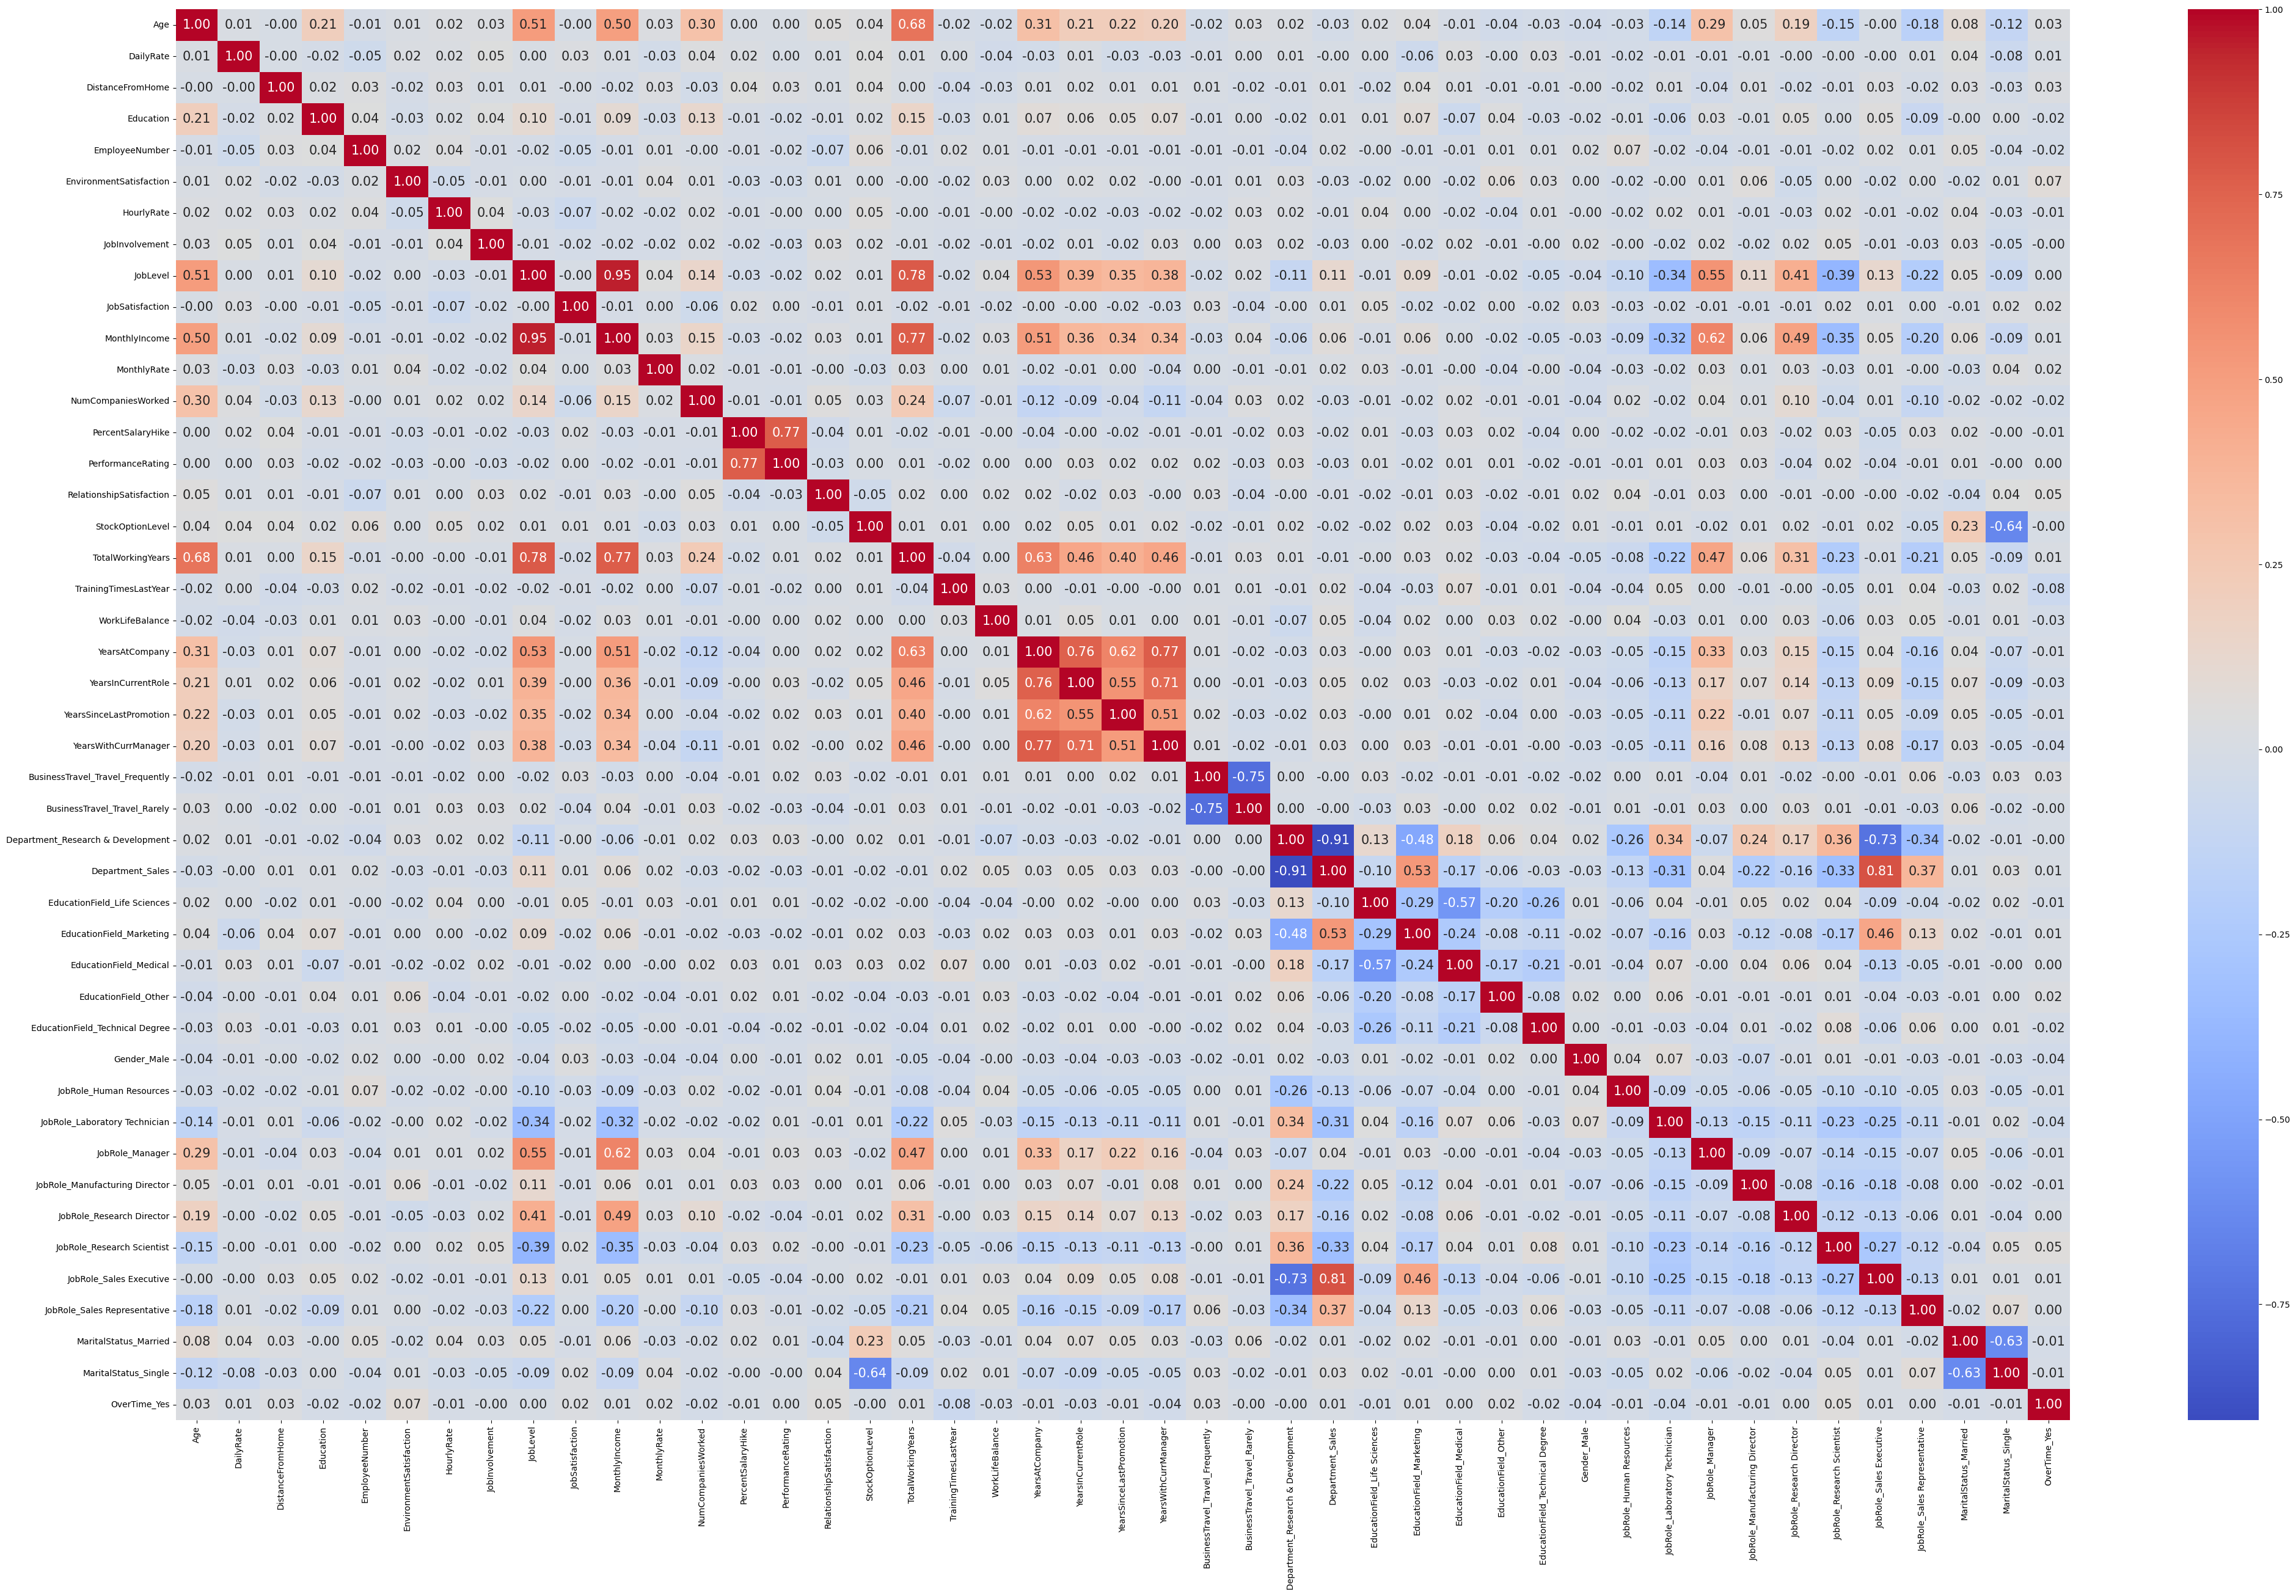

In [15]:
plt.figure(figsize=(50,30))
sns.heatmap(corr, cbar=True, fmt='.2f', annot=True, annot_kws={'size':15}, cmap='coolwarm')

* from the map above we can see that we have the same insights from different columns **(JobLevel and MonthelyIncome)and(Department_Research & Development and Department_Sales)** so we can drop 2 of the 4 columns to avoid noisy in our model

In [16]:
new_df.drop(['Department_Sales','JobLevel'],axis=1,inplace=True)

# **Split the data**

In [17]:
train=new_df.iloc[:1058,:]
test=new_df.iloc[1059:,:]

In [18]:
from sklearn.model_selection import train_test_split
X = train
y = train_df['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size = 0.2, random_state = 0)

# **Training the model**

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

## Logistic Regression

In [20]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_predictions = logreg.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_predictions)
print("Logistic Regression Accuracy:", logreg_accuracy)
print(classification_report(y_test, logreg_predictions))

Logistic Regression Accuracy: 0.8679245283018868
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       182
           1       0.75      0.10      0.18        30

    accuracy                           0.87       212
   macro avg       0.81      0.55      0.55       212
weighted avg       0.85      0.87      0.82       212



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## SVM

In [ ]:
svm = SVC()
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)
print(classification_report(y_test, svm_predictions))

## Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)
print(classification_report(y_test, rf_predictions))

## K-Neighbors Classifier

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)
print(classification_report(y_test, knn_predictions))